<img align="right" src="https://ds-cs-images.s3.ap-northeast-2.amazonaws.com/Codestates_Fulllogo_Color.png" width=100>

## *DATA SCIENCE / SECTION 2 / SPRINT 2 / NOTE 4*

---

# Model Tuning

## 🏆 학습목표
1. 여러 하이퍼파라미터 튜닝 방법을 이해하고 이를 사용해 모델의 성능을 최적화할 수 있다.
2. 모델 성능을 향상시키고 효율화하기 위해 학습에서 유용한 특성을 선택해서 사용할 수 있다.

### Warm up

#### 다음 영상을 시청하세요:
[Random Search CV vs Grid Search CV for Hyper-parameter Optimization in Machine Learning](https://youtu.be/2D5u07ysB7A)
- Randomizse Search와 Grid Search의 차이점은 무엇인가요?

### 📚 아래 라이브러리를 설치해 주세요.

#### 이번 모듈에서 추가적으로 사용하는 라이브러리는 다음과 같습니다. 설치를 확인해 주세요.
- [**hyperopt**](http://hyperopt.github.io/hyperopt/)

In [1]:
!pip3 install hyperopt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip3 install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 KB 2.7 MB/s eta 0:00:00


# 1. 하이퍼파라미터 튜닝
- 하이퍼파라미터 튜닝은 모델 학습에서의 필수적인 단계입니다.
- 각 모델들은 미리 설정해줄 수 있는 모델 구조 또는 학습과 관련된 옵션들을 갖고 있습니다. 이들을 **하이퍼파라미터**라고 합니다.
  - 트리 기반 모델에서는 `max_depth`, `min_samples_split` 등이 주요 하이퍼파라미터입니다.
  - 릿지 회귀 모델에서는 `alpha`(규제 정도) 등이 있습니다.

### 하이퍼파라미터 튜닝의 기본 요소
- 하이퍼파라미터 튜닝에는 다양한 방법이 존재하나, 아래와 같은 기본 요소들을 공통적으로 필요로 합니다.

1. 튜닝 대상 모델(`sklearn.linear_model.Ridge`, `xgboost.XGBRegressor` 등)
2. 탐색할 하이퍼파라미터의 범위(`0 <= alpha <= 5`, `3 <= max_depth <= 12` 등)
3. 설정한 범위 내에서 하이퍼파라미터 조합을 선택하는 방법(Random 선택, 모든 조합 시도(Exhaustive)해보기 등)
4. 검증 방법(Cross Validation, 검증용 Validation set 제공 등)
5. **scoring metric**(`accuracy`, `f1`, `mse`...): 이 metric 값이 가장 우수한 하이퍼파라미터 조합을 선택하게 됩니다.

- 하이퍼파라미터 튜닝을 수행할 때, 각 기본 요소들을 명확히 정의했는지 확인하는 단계가 반드시 필요합니다.
  - scoring function 등을 명확히 정의하지 않으면 의도하지 않은 하이퍼파라미터 조합이 선택될 수 있습니다.
- 하이퍼파라미터를 튜닝할 수 있는 여러 방법들을 소개합니다.

## 직접 튜닝
- 데이터 및 각 하이퍼파라미터의 특성을 이해하고 있는 개발자가 각 하이퍼파라미터가 갖는 임팩트에 대한 본인의 경험을 바탕으로 직접 하이퍼파라미터를 튜닝할 수 있습니다.
- 여타 기계적인 툴들을 이용하기 전, 적절한 하이퍼파라미터의 범위 등에 대해 대략적으로 감을 잡기 위해 **필수적인 과정**입니다.
  - 하이퍼파라미터 튜닝의 전 과정을 Grid Search 등 추후 배울 여러 툴들에만 온전히 의존한다면 데이터 및 모델의 특성에 대한 개발자의 직관과 통찰을 얻기 힘듭니다.
- 현 데이터에 대한 과적합 여부를 판단하고, 각 피쳐 간의 상호작용 등이 충분히 반영되었는지를 살펴본 후 이에 맞는 하이퍼파라미터를 조정합니다.

- 이 방법은 많은 시도 및 학습 자료만으로는 얻을 수 없는 직관을 요하기 때문에 이 과정을 생략하기 쉬우나, 매우 중요한 모델링 과정의 하나입니다. 
- 대부분의 상황에서 적용될 수 있는 직접 튜닝 과정에서의 몇 가지 팁을 제시합니다.

#### 1. 많은 하이퍼파라미터들을 Default 값으로 두고, 3개 이내의 중요한 하이퍼파라미터부터 값을 바꿔 가며 모델 성능의 변화를 살펴봅니다.
   - `sklearn`, `xgboost` 등의 라이브러리가 굉장히 많은 하이퍼파라미터 옵션을 제공하지만, 대개의 경우 일부 하이퍼파라미터만이 성능에 중요한 영향을 미칩니다.
     - 트리 기반 모델에서는 `max_depth`가 성능에 영향을 많이 줍니다.
     - 부스팅 모델(`GBDT`)에서는 `max_depth`, `learning_rate` 등이 성능에 영향을 많이 줍니다.
     - 선형 기반 회귀 모델(`Ridge`, `Logistic` 등)에서는 규제의 정도를 조정하는 하이퍼파라미터(`alpha`, `C`)들이 성능에 영향을 많이 줍니다.
   - 중요한 하이퍼파라미터부터 조정해 가며 성능을 안정화한 후, 해당 값들을 고정하고 필요하다면 추가로 다른 하이퍼파라미터들을 조정합니다.

#### 2. 대다수의 하이퍼파라미터들이 모델의 복잡성과 관련된 것들입니다. 과적합 / 과소적합의 여부를 확인하고, 모델의 복잡성을 조절한다고 생각하고 하이퍼파라미터를 튜닝합니다.
   - 트리 기반 모델의 `max_depth`는 커질수록 모델의 복잡성을 증가시킵니다. 반대로 `min_samples_split`, `min_samples_leaf` 등은 커질수록 모델을 단순하게 만듭니다.
   - 각 하이퍼파라미터가 모델의 복잡성에 갖는 영향을 파악하고, 이를 기반으로 하이퍼파라미터의 튜닝을 모델 복잡성의 관점에서 바라보고 시작하는 것이 좋습니다.


## Exhaustive Grid Search
- 검증하고자 하는 하이퍼파라미터의 범위 내에서 모든 조합에 대해 모델을 학습하고, 그 중 가장 metric이 좋은 조합을 선택합니다.
- 검증 결과를 바탕으로 각 하이퍼파라미터들이 성능에 미치는 영향을 직관적으로 이해하기 쉽습니다.
- 하지만 검증해야 할 하이퍼파라미터 조합의 수가 굉장히 크므로, 튜닝할 하이퍼파라미터의 수가 많을 때는 효율적이지는 못합니다.

## Randomized Search
- 검증하고자 하는 하이퍼파라미터의 범위 내에서 랜덤으로 몇 개의 조합을 선택하고, 그 중 가장 metric이 좋은 조합을 선택합니다.
- 탐색의 횟수를 지정해주므로, 검증하고자 하는 하이퍼파라미터 수가 많고 범위가 넓더라도 탐색할 수 있습니다.
- 하지만 모든 조합에 대해 검증하지는 않으므로, 가장 이상적인 조합을 발견하기 어려울 수도 있습니다.

## Bayesian Search
- 검증하고자 하는 하이퍼파라미터의 범위 내에서, 이전에 탐색한 조합들의 성능을 기반으로 성능이 잘 나오는 조합들을 중심으로 확률적으로 탐색합니다.
- 랜덤 서치보다 상대적으로 똑똑하고 효율적으로 탐색하는 방법으로, 한정된 자원 내에서 좋은 하이퍼파라미터 조합을 발견할 가능성이 더 높습니다.
- `sklearn`에서는 이 기능을 제공하지 않으며, 일반적으로 `hyperopt` 등의 라이브러리를 추가 사용해서 탐색을 진행하게 됩니다.

### 💉 Case Study: H1N1 Vaccination Dataset
- Kaggle Competition에서 사용했던 H1N1 Vaccination 예측 Task를 예시로 하이퍼파라미터 탐색 과정을 적용해 봅시다.

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

target = "vacc_h1n1_f"
train = pd.merge(
    pd.read_csv(
        "https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/train.csv"
    ),
    pd.read_csv(
        "https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/train_labels.csv"
    )[target],
    left_index=True,
    right_index=True,
)
test = pd.read_csv(
    "https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/test.csv"
)

# Feature Engineering을 수행합니다.
def engineer(df):
    # 새로운 특성을 생성합니다.
    behaviorals = [col for col in df.columns if "behavioral" in col]
    df["behaviorals"] = df[behaviorals].sum(axis=1)

    # 사용하지 않는 특성을 drop합니다.
    dels = [col for col in df.columns if ("employment" in col or "seas" in col)]
    df.drop(columns=dels, inplace=True)
    return df


train = engineer(train.copy())
test = engineer(test.copy())

# feature과 label을 분리합니다.
X_train, y_train = train.drop(columns=target), train[target]
X_test = test

### 학습에 사용할 파이프라인을 구성해 줍니다.

In [4]:
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy="median"),
    XGBClassifier(
        objective="binary:logistic",
        eval_metric="error",
        n_estimators=200,
        random_state=42,
        n_jobs=-1,
        learning_rate=0.1,
        use_label_encoder=False,
    ),
)
print(pipe)

Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                ('simpleimputer', SimpleImputer(strategy='median')),
                ('xgbclassifier',
                 XGBClassifier(eval_metric='error', n_estimators=200, n_jobs=-1,
                               random_state=42, use_label_encoder=False))])


### 아래와 같이 탐색할 하이퍼파라미터와 범위를 지정해 줍니다.

In [5]:
params = {
    "xgbclassifier__max_depth": [2, 4, 6],
    "xgbclassifier__min_child_weight": [2, 4, 8],
    "xgbclassifier__colsample_bytree": [0.6, 0.8, 1.0],
}

### Exhaustive Grid Search를 진행하겠습니다. 몇 번의 Fitting이 진행될까요?
- sklearn에서 제공하는 Grid Search는 교차검증(cross validation)의 방법으로 탐색을 진행합니다.
- 각 파라미터 조합 $3 \times 3 \times 3$에 cv 3을 곱하여 81번의 fitting이 이루어집니다!
- [sklearn.model_selection.GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

In [6]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(pipe, param_grid=params, scoring="roc_auc", cv=3, verbose=3)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV 1/3] END xgbclassifier__colsample_bytree=0.6, xgbclassifier__max_depth=2, xgbclassifier__min_child_weight=2;, score=0.820 total time=   5.6s
[CV 2/3] END xgbclassifier__colsample_bytree=0.6, xgbclassifier__max_depth=2, xgbclassifier__min_child_weight=2;, score=0.818 total time=  12.4s
[CV 3/3] END xgbclassifier__colsample_bytree=0.6, xgbclassifier__max_depth=2, xgbclassifier__min_child_weight=2;, score=0.813 total time=  13.0s
[CV 1/3] END xgbclassifier__colsample_bytree=0.6, xgbclassifier__max_depth=2, xgbclassifier__min_child_weight=4;, score=0.820 total time=   2.8s
[CV 2/3] END xgbclassifier__colsample_bytree=0.6, xgbclassifier__max_depth=2, xgbclassifier__min_child_weight=4;, score=0.818 total time=   2.7s
[CV 3/3] END xgbclassifier__colsample_bytree=0.6, xgbclassifier__max_depth=2, xgbclassifier__min_child_weight=4;, score=0.813 total time=   2.7s
[CV 1/3] END xgbclassifier__colsample_bytree=0.6, xgbclassifier__max_

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                                       ('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('xgbclassifier',
                                        XGBClassifier(eval_metric='error',
                                                      n_estimators=200,
                                                      n_jobs=-1,
                                                      random_state=42,
                                                      use_label_encoder=False))]),
             param_grid={'xgbclassifier__colsample_bytree': [0.6, 0.8, 1.0],
                         'xgbclassifier__max_depth': [2, 4, 6],
                         'xgbclassifier__min_child_weight': [2, 4, 8]},
             scoring='roc_auc', verbose=3)

In [ ]:
print("최적 하이퍼파라미터: ", grid_search.best_params_)
print("최적 AUC: ", grid_search.best_score_)

최적 하이퍼파라미터:  {'xgbclassifier__colsample_bytree': 0.6, 'xgbclassifier__max_depth': 4, 'xgbclassifier__min_child_weight': 8}
최적 AUC:  0.8207693120569851


In [ ]:
# 최적의 조합은 모델로 test data 에 predict한 값을 캐글 제출

In [ ]:
best_model = randomized_search.best_estimator_ # 모델 다시 fit 해야할까? No
X_train.columns[best.naemd_steps['selectkbest'].get_support().tolist()]

In [ ]:
y_pred = best_model.predict(X_val)
f1_score(y_val, y_pred)

### 각 하이퍼파라미터 조합으로 만들어진 모델들을 순위별로 나열해 봅니다.
- `rank_test_score`: 테스트 순위
- `mean_score_time`: 예측에 걸리는 시간

In [ ]:
pd.DataFrame(grid_search.cv_results_).sort_values(by="rank_test_score").T

,5,4,14,13,3,23,12,21,22,8,...,19,18,20,7,6,16,26,15,25,24
mean_fit_time,4.253661,4.269322,4.754583,4.751566,4.259149,5.293021,4.776222,5.371645,5.313496,7.116952,...,3.180018,3.207472,3.207341,6.490504,6.642978,7.446348,8.23685,7.515054,8.41893,8.453621
std_fit_time,0.016934,0.025879,0.020817,0.025512,0.014765,0.029355,0.01721,0.012731,0.017813,0.663087,...,0.034581,0.022661,0.020728,0.039329,0.056807,0.038102,0.043826,0.016601,0.028104,0.019743
mean_score_time,0.128682,0.132231,0.131412,0.134035,0.132749,0.12723,0.132763,0.130614,0.132814,0.179928,...,0.096723,0.094079,0.097255,0.173847,0.173273,0.174258,0.168056,0.169257,0.17039,0.167178
std_score_time,0.001506,0.003888,0.002692,0.007799,0.007186,0.001096,0.001451,0.003927,0.007807,0.013674,...,0.004815,0.000315,0.002084,0.007764,0.010371,0.009657,0.002293,0.005761,0.010102,0.004133
param_xgbclassifier__colsample_bytree,0.6,0.6,0.8,0.8,0.6,1.0,0.8,1.0,1.0,0.6,...,1.0,1.0,1.0,0.6,0.6,0.8,1.0,0.8,1.0,1.0
param_xgbclassifier__max_depth,4,4,4,4,4,4,4,4,4,6,...,2,2,2,6,6,6,6,6,6,6
param_xgbclassifier__min_child_weight,8,4,8,4,2,8,2,2,4,8,...,4,2,8,4,2,4,8,2,4,2
params,"{'xgbclassifier__colsample_bytree': 0.6, 'xgbc...","{'xgbclassifier__colsample_bytree': 0.6, 'xgbc...","{'xgbclassifier__colsample_bytree': 0.8, 'xgbc...","{'xgbclassifier__colsample_bytree': 0.8, 'xgbc...","{'xgbclassifier__colsample_bytree': 0.6, 'xgbc...","{'xgbclassifier__colsample_bytree': 1.0, 'xgbc...","{'xgbclassifier__colsample_bytree': 0.8, 'xgbc...","{'xgbclassifier__colsample_bytree': 1.0, 'xgbc...","{'xgbclassifier__colsample_bytree': 1.0, 'xgbc...","{'xgbclassifier__colsample_bytree': 0.6, 'xgbc...",...,"{'xgbclassifier__colsample_bytree': 1.0, 'xgbc...","{'xgbclassifier__colsample_bytree': 1.0, 'xgbc...","{'xgbclassifier__colsample_bytree': 1.0, 'xgbc...","{'xgbclassifier__colsample_bytree': 0.6, 'xgbc...","{'xgbclassifier__colsample_bytree': 0.6, 'xgbc...","{'xgbclassifier__colsample_bytree': 0.8, 'xgbc...","{'xgbclassifier__colsample_bytree': 1.0, 'xgbc...","{'xgbclassifier__colsample_bytree': 0.8, 'xgbc...","{'xgbclassifier__colsample_bytree': 1.0, 'xgbc...","{'xgbclassifier__colsample_bytree': 1.0, 'xgbc..."
split0_test_score,0.82388,0.823328,0.822586,0.822513,0.823126,0.821318,0.822211,0.821354,0.821598,0.819907,...,0.819812,0.81959,0.819901,0.819237,0.819167,0.817451,0.818563,0.817592,0.816346,0.816051
split1_test_score,0.822177,0.821977,0.822604,0.822661,0.821528,0.822005,0.821455,0.821827,0.820407,0.818859,...,0.818325,0.818286,0.817987,0.818089,0.818938,0.817659,0.815423,0.816379,0.816903,0.814736


### Randomized Search는 더 많은 하이퍼파라미터의 더 넓은 범위를 탐색할 수 있습니다.
- sklearn에서 제공하는 Randomized Search는 교차검증(cross validation)의 방법으로 탐색을 진행합니다.
- 하이퍼파라미터 범위로 값을 지정해줄 수도 있고, `scipy.stats`의 분포로 지정해줄 수도 있습니다.
- 설정해 주는 하이퍼파라미터의 범위는 넓지만, fitting은 설정해 준 `n_iter`(=10)만큼만 진행됩니다.
- [sklearn.model_selection.RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV)

In [ ]:
from scipy.stats.distributions import uniform

params = {
    "simpleimputer__strategy": ["median", "mean"],
    "xgbclassifier__max_depth": [2, 4, 6],
    "xgbclassifier__min_child_weight": [2, 4, 8],
    "xgbclassifier__colsample_bytree": uniform(
        loc=0.5, scale=0.5
    ),  # 0.5 ~ 1 사이의 uniform 분포로 범위를 지정해 줍니다.
}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

randomized_search = RandomizedSearchCV(
    pipe,
    param_distributions=params,
    scoring="roc_auc",
    n_iter=10,
    cv=3,     # 10 * 3 = 30 times of fitting
    verbose=3,
    random_state=42,
)
randomized_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END simpleimputer__strategy=median, xgbclassifier__colsample_bytree=0.8982714934301164, xgbclassifier__max_depth=6, xgbclassifier__min_child_weight=8;, score=0.819 total time=   7.9s
[CV 2/3] END simpleimputer__strategy=median, xgbclassifier__colsample_bytree=0.8982714934301164, xgbclassifier__max_depth=6, xgbclassifier__min_child_weight=8;, score=0.817 total time=   7.9s
[CV 3/3] END simpleimputer__strategy=median, xgbclassifier__colsample_bytree=0.8982714934301164, xgbclassifier__max_depth=6, xgbclassifier__min_child_weight=8;, score=0.811 total time=   7.8s
[CV 1/3] END simpleimputer__strategy=mean, xgbclassifier__colsample_bytree=0.7993292420985183, xgbclassifier__max_depth=6, xgbclassifier__min_child_weight=4;, score=0.846 total time=   7.6s
[CV 2/3] END simpleimputer__strategy=mean, xgbclassifier__colsample_bytree=0.7993292420985183, xgbclassifier__max_depth=6, xgbclassifier__min_child_weight=4;, score=0.849 to

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder()),
                                             ('simpleimputer',
                                              SimpleImputer(strategy='median')),
                                             ('xgbclassifier',
                                              XGBClassifier(eval_metric='error',
                                                            n_estimators=200,
                                                            n_jobs=-1,
                                                            random_state=42,
                                                            use_label_encoder=False))]),
                   param_distributions={'simpleimputer__strategy': ['median',
                                                                    'mean'],
                                        'xgbclassifier__colsample_bytree': <scipy.stats.

In [ ]:
print("최적 하이퍼파라미터: ", randomized_search.best_params_)
print("최적 AUC: ", randomized_search.best_score_)

최적 하이퍼파라미터:  {'simpleimputer__strategy': 'mean', 'xgbclassifier__colsample_bytree': 0.5714334089609704, 'xgbclassifier__max_depth': 6, 'xgbclassifier__min_child_weight': 4}
최적 AUC:  0.8463799826320814


In [ ]:
pd.DataFrame(randomized_search.cv_results_).sort_values(by="rank_test_score").T

,3,8,1,9,5,6,4,2,7,0
mean_fit_time,6.576167,6.616326,7.38841,7.6598,2.493378,2.791649,5.267249,7.374652,7.204557,7.685053
std_fit_time,0.309656,0.058647,0.047912,0.03689,0.005304,0.031788,0.012067,1.526425,0.018958,0.075671
mean_score_time,0.178639,0.163527,0.169319,0.168813,0.100414,0.097603,0.133944,0.169711,0.167304,0.16966
std_score_time,0.009651,0.002354,0.003796,0.00405,0.009448,0.006537,0.007633,0.004294,0.00405,0.001849
param_simpleimputer__strategy,mean,mean,mean,mean,mean,mean,median,median,median,median
param_xgbclassifier__colsample_bytree,0.571433,0.646072,0.799329,0.892588,0.590912,0.805827,0.984955,0.549987,0.762387,0.898271
param_xgbclassifier__max_depth,6,6,6,6,2,2,4,6,6,6
param_xgbclassifier__min_child_weight,4,4,4,8,2,2,4,2,4,8
params,"{'simpleimputer__strategy': 'mean', 'xgbclassi...","{'simpleimputer__strategy': 'mean', 'xgbclassi...","{'simpleimputer__strategy': 'mean', 'xgbclassi...","{'simpleimputer__strategy': 'mean', 'xgbclassi...","{'simpleimputer__strategy': 'mean', 'xgbclassi...","{'simpleimputer__strategy': 'mean', 'xgbclassi...","{'simpleimputer__strategy': 'median', 'xgbclas...","{'simpleimputer__strategy': 'median', 'xgbclas...","{'simpleimputer__strategy': 'median', 'xgbclas...","{'simpleimputer__strategy': 'median', 'xgbclas..."
split0_test_score,0.847919,0.848493,0.846384,0.846957,0.847098,0.846547,0.821312,0.820104,0.817841,0.819167


### `hyperopt` 라이브러리를 사용해 Bayesian Search를 진행해 보겠습니다.
- `hyperopt` 라이브러리를 이용해 하이퍼파라미터를 탐색할 때는 하이퍼파라미터 범위를 `hyperopt` 라이브러리에서 제공하는 `stochastic expressions`로 지정해 주어야 합니다.
- 몇 가지 자주 사용하는 `expression`들을 소개합니다.

    - `hp.choice(label, options)`: 리스트나 튜플 형태의 선택지 중 하나를 선택합니다.

    - `hp.randint(label, upper)`: [0, upper] 범위 내의 정수값을 랜덤으로 선택합니다.

    - `hp.uniform(label, low, high)`: [low, high] 범위 내의 실수값을 랜덤으로 선택합니다.

    - `hp.quniform(label, low, high, q)`: [low, high] 사이 균등분포에서 q 간격의 일정 지점들로부터 값을 랜덤으로 선택합니다.

    - `hp.normal(label, mu, sigma)`: 평균 mu, 표준편차 sigma를 갖는 정규분포로부터 실수값을 랜덤으로 선택합니다.

- 자세한 내용은 [여기](http://hyperopt.github.io/hyperopt/getting-started/search_spaces/)를 참고하세요.

In [ ]:
from hyperopt import hp

params = {
    "simpleimputer__strategy": hp.choice("strategy", ["median", "mean"]),
    "xgbclassifier__max_depth": hp.quniform("max_depth", 2, 10, 2),
    "xgbclassifier__min_child_weight": hp.quniform("min_child_weight", 2, 10, 2),
    "xgbclassifier__colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1.0),
}

### `hyperopt` 라이브러리 사용 시 학습 및 검증 함수를 직접 작성해 주어야 합니다.
- `hyperopt.fmin`은 주어진 함수로부터 loss 정보를 얻고, 이 정보로부터 다음 탐색할 하이퍼파라미터 조합을 선택합니다.
- 최종으로 `loss`를 가장 작게 만드는 하이퍼파라미터 조합을 선택하므로, 클수록 좋은 metric의 경우 - 부호를 붙여 반환해 주어야 합니다.
- 따라서 학습 및 검증을 위한 함수는 아래와 같이 loss와 status라는 상태를 반환해야 합니다.
- `fmin`의 `max_evals`만큼의 하이퍼파라미터 조합을 탐색하게 됩니다.

In [ ]:
# 밑의 함수를 쓰고싶지 않다면 (int로 변경하는 함수), 

In [ ]:
from hyperopt import fmin, tpe, Trials, STATUS_OK
from sklearn.model_selection import cross_val_score
import numpy as np


def get_pipe(params):
    params["xgbclassifier__max_depth"] = int(
        params["xgbclassifier__max_depth"]
    )  # return max_depth in integer -> float 그대로 놔두게 되면 error가 생길수 있다.
    pipe = make_pipeline(
        OrdinalEncoder(),
        SimpleImputer(strategy="median"),
        XGBClassifier(
            objective="binary:logistic",
            eval_metric="error",
            n_estimators=200,
            random_state=42,
            n_jobs=-1,
            learning_rate=0.1,
            use_label_encoder=False,
        ),
    )
    pipe = pipe.set_params(**params)   # set the parameters as we define
    return pipe


def fit_and_eval(params):
    pipe = get_pipe(params)  # 주어진 params로 파이프라인을 만들어 가져옵니다.
    score = cross_val_score(pipe, X_train, y_train, cv=3, scoring="roc_auc")
    avg_cv_score = np.mean(score)
    # roc_auc는 클수록 좋은 metric이므로, hyperopt.fmin이 roc_auc를 최대화하도록 하기 위해 -부호를 붙여 반환합니다.
    return {"loss": -avg_cv_score, "status": STATUS_OK}


trials = (
    Trials()
)  # Trials() 객체를 fmin에 함께 넣어 실행하면, 실행되는 매 fit의 학습 정보 및 학습 결과가 해당 객체에 모두 저장됩니다.

best_params = fmin(
    fn=fit_and_eval, trials=trials, space=params, algo=tpe.suggest, max_evals=10,
    rstate = np.random.RandomState(2023)
)  # max_evals 횟수만큼 하이퍼파라미터 조합을 탐색합니다.
# fmin: Minimize a function using the downhill simplex algorithm. This algorithm only uses function values, not derivatives or second derivatives.

100%|██████████| 10/10 [03:59<00:00, 23.94s/it, best loss: -0.8481357134852431]


In [ ]:
trials.trials  # 모든 trial 정보에 대해 직접 접근할 수 있습니다.

[{'state': 2,
  'tid': 0,
  'spec': None,
  'result': {'loss': -0.8155592873608254, 'status': 'ok'},
  'misc': {'tid': 0,
   'cmd': ('domain_attachment', 'FMinIter_Domain'),
   'workdir': None,
   'idxs': {'colsample_bytree': [0],
    'max_depth': [0],
    'min_child_weight': [0],
    'strategy': [0]},
   'vals': {'colsample_bytree': [0.8896926982367929],
    'max_depth': [6.0],
    'min_child_weight': [8.0],
    'strategy': [0]}},
  'exp_key': None,
  'owner': None,
  'version': 0,
  'book_time': datetime.datetime(2023, 1, 6, 6, 51, 36, 941000),
  'refresh_time': datetime.datetime(2023, 1, 6, 6, 52, 0, 829000)},
 {'state': 2,
  'tid': 1,
  'spec': None,
  'result': {'loss': -0.809463784724977, 'status': 'ok'},
  'misc': {'tid': 1,
   'cmd': ('domain_attachment', 'FMinIter_Domain'),
   'workdir': None,
   'idxs': {'colsample_bytree': [1],
    'max_depth': [1],
    'min_child_weight': [1],
    'strategy': [1]},
   'vals': {'colsample_bytree': [0.581703388084142],
    'max_depth': [8.0],

### 탐색을 통해 발견한 최적 하이퍼파라미터 조합을 확인해 봅시다.

In [ ]:
print("최적 하이퍼파라미터: ", trials.best_trial["misc"]["vals"])
print("최적 AUC: ", -trials.best_trial["result"]["loss"])

최적 하이퍼파라미터:  {'colsample_bytree': [0.8815768328637574], 'max_depth': [4.0], 'min_child_weight': [2.0], 'strategy': [1]}
최적 AUC:  0.8481357134852431


# 2. 특성 선택
- 충분한 데이터가 보장되어 있는 대부분의 머신러닝 상황에서는 예측에 중요하지 않은 특성이 학습 데이터에 포함되더라도 모델의 성능이 크게 하락하지 않습니다.
  - 모델 학습 과정에서 중요하지 않은 특성이 모델의 예측에 자동으로 덜 반영되기 때문입니다.
- 하지만 데이터가 충분하지 않은 상황에서는 불필요한 특성이 과적합을 유발할 수 있습니다.
- 또한 불필요한 특성을 학습 데이터에서 배제함으로써 모델 학습 및 추론 과정에서의 효율을 향상시킬 수 있습니다.
- 데이터로부터 주요 특성을 선택하고 불필요한 특성을 배제하는 몇 가지 방법에 대해 알아봅시다.

## 직관에 기반한 특성 선택
- 데이터의 각 특성에 대해 충분히 이해하고 있는 개발자가 주요하지 않은 특성을 선제적으로 배제하는 방법으로, 대부분의 경우에서 가장 일반적이면서 동시에 필수적인 방법입니다.
- 예를 들어, 사용자에게 상품을 추천하는 문제를 머신러닝으로 모델링할 때, 사용자의 고유 ID나 이름 등은 추천에 영향이 없을 것입니다(없어야 할 것입니다).
- 이러한 특성들은 학습 전에 선제적으로 제거함으로써 모델 학습 시간을 단축시키고 효율성을 높일 수 있습니다.

## 특성 중요도 기반 특성 선택
- 모델 학습 이후, 각 특성의 모델 예측에 대한 중요도를 기반으로 특성을 선택하는 방법도 있습니다.
- 선형 회귀 기반 모델의 경우 `coefficient`를 통해, 트리 기반 모델의 경우 자체 `feature_importance`를 통해 특성의 중요도에 대한 수치값을 얻을 수 있습니다. 이를 기반으로, 특정 값 아래 (threshold 정해보기)의 중요도를 갖는 특성들을 drop할 수 있습니다.
- 추후 `n231`에서 여러 특성 중요도 계산 방법을 배우게 됩니다. 이 방법들을 사용하면 위 방법보다 정교하게 예측에 대한 특성의 영향력을 수치화할 수 있으며, 이를 기반으로 중요하지 않은 특성들을 drop할 수 있게 됩니다.

In [ ]:
train_sub, val = train_test_split(train, test_size=0.2, stratify=train[target], random_state=42)
X_train, y_train = train_sub.drop(columns=target), train_sub[target]
X_val, y_val = val.drop(columns=target), val[target]

pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy="mean"),
    XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        n_estimators=200,
        random_state=42,
        n_jobs=-1,
        max_depth=6,
        min_child_weight=6,
        colsample_bytree=0.7,
        learning_rate=0.1,
        use_label_encoder=False,
    ),
)

pipe.fit(X_train, y_train)
print("검증 AUC: ", pipe.score(X_val, y_val))

검증 AUC:  0.8271853872612976


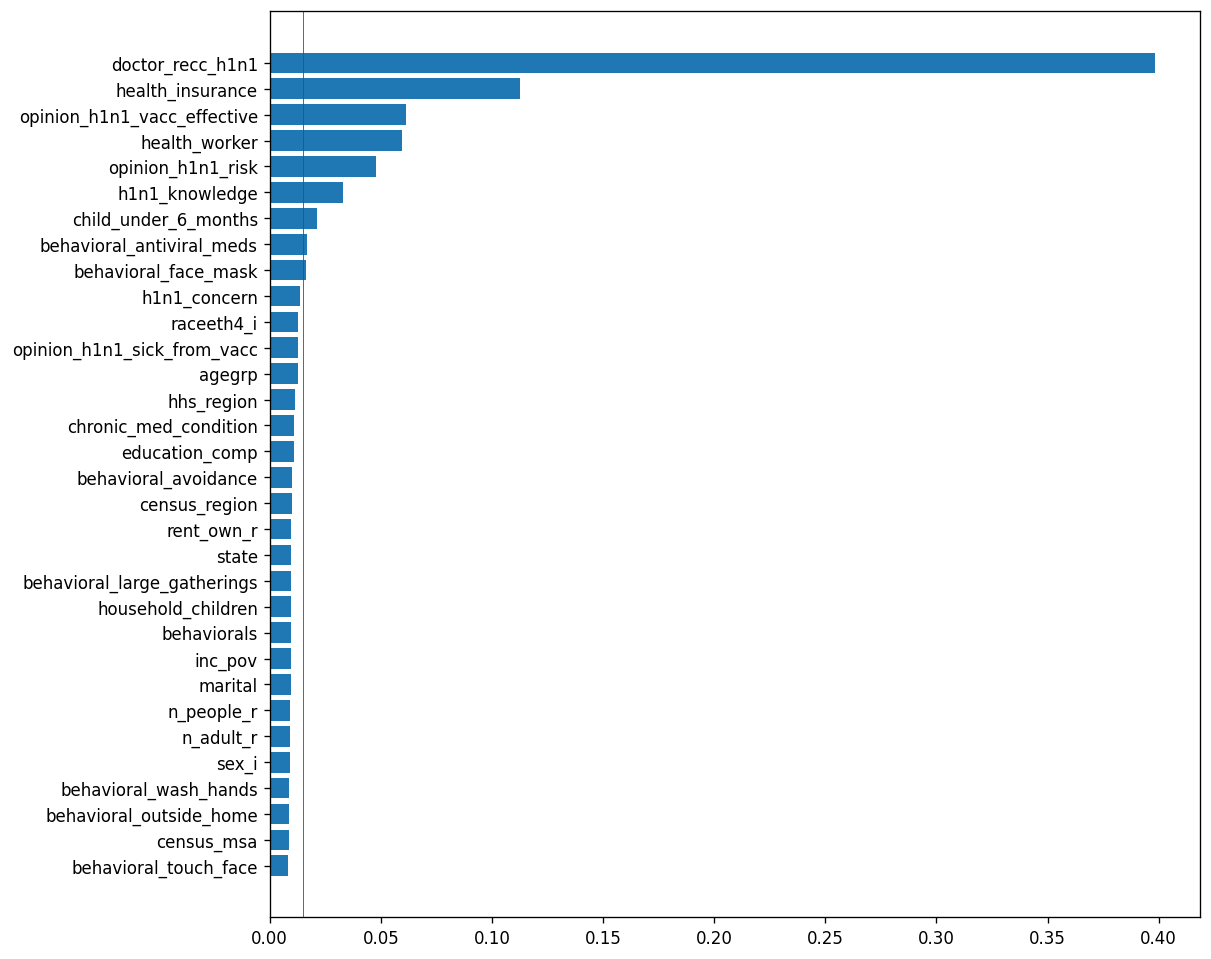

In [ ]:
import matplotlib.pyplot as plt

feature_importances = list(
    zip(X_train.columns, pipe.named_steps["xgbclassifier"].feature_importances_)
)
feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)

plt.figure(figsize=(10, 10), dpi=120)
plt.barh(*list(zip(*feature_importances[::-1])))
plt.axvline(0.015, color="red", linewidth=0.5)    # threshold=0.015 -> 이 선을 기준으로 아래에 있는 feature 들은 제거

### 특성 중요도 0.015 미만인 특성들을 Drop 후 재학습해 봅시다.

In [ ]:
features_selected = list(filter(lambda x: x[1] >= 0.015, feature_importances))
print(features_selected)
selected_feature_names = list(map(lambda x: x[0], features_selected))

[('doctor_recc_h1n1', 0.3985201), ('health_insurance', 0.112448685), ('opinion_h1n1_vacc_effective', 0.061225325), ('health_worker', 0.059696328), ('opinion_h1n1_risk', 0.047750548), ('h1n1_knowledge', 0.032819603), ('child_under_6_months', 0.02129474), ('behavioral_antiviral_meds', 0.016921392), ('behavioral_face_mask', 0.016461179)]


In [ ]:
X_train_selected = X_train[selected_feature_names]
X_val_selected = X_val[selected_feature_names]

pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy="mean"),
    XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        n_estimators=200,
        random_state=42,
        n_jobs=-1,
        max_depth=6,
        min_child_weight=6,
        colsample_bytree=0.7,
        learning_rate=0.1,
        use_label_encoder=False,
    ),
)

pipe.fit(X_train_selected, y_train)
print("검증 AUC: ", pipe.score(X_val_selected, y_val))
print("특성 수:")
print("\tBefore: ", X_train.shape[1])
print("\tAfter: ", X_train_selected.shape[1])

검증 AUC:  0.8254062388803226
특성 수:
	Before:  32
	After:  9


검증 auc가 거의 변화가 없다. 특성수를 줄임으로써 학습이나 예측은 훨씬 더 빠르게 할 수 있을 것이다.

## 통계량 기반 특성 선택
- 모델 학습 이전에, 각 특성들과 타겟값 간의 통계량으로부터 각 특성의 영향력을 추측하여 낮은 영향력을 갖는 특성들을 제거할 수 있습니다.

### 피어슨 상관계수
- 연속형 특성과 연속형 타겟의 경우, 두 필드 간의 피어슨 상관계수를 통해 관련도를 추측할 수 있습니다.

$$ \rho = \frac{\Sigma_{i}^{n}(x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\Sigma_{i}^{n}(x_i - \bar{x})^2 }\sqrt{\Sigma_{i}^{n}(y_i - \bar{y})^2}}$$
- 피어슨 상관계수는 `np.corrcoef`를 사용해 쉽게 구할 수 있습니다. 하지만 두 특성 간의 선형 관계성만 확인할 수 있다는 단점이 있습니다.


### 스피어만 상관계수
- 스피어만 상관계수는 두 특성의 선형성이 아닌 단조성을 보여줍니다. 즉, 한 특성이 커질 때 다른 특성이 함께 커지는지를 수치화해 줍니다.
- 스피어만 상관계수는 각 특성의 값들을 그 값의 전체에서의 순위로 대치한 다음, 피어슨 상관계수를 구한 것과 동일합니다.
- 스피어만 상관계수는 `scipy.stats.spearmanr`을 사용해 구할 수 있습니다.


- 피어슨 / 스피어만 상관계수 통계량을 이용해, 타겟값과의 통계량이 상위 K 내에 드는 특성들만 선택하거나, 적절한 threshold를 지정하여 해당 값 이상의 통계량을 갖는 특성들만 학습에 이용할 수 있습니다.

Pearson Corrcoef: 0.9987555743010837
Spearman Corrcoef: SpearmanrResult(correlation=0.9985200385200387, pvalue=0.0)


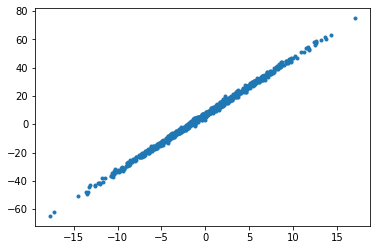

In [ ]:
from scipy.stats import spearmanr

# 두 특성이 선형 관계일 때 pearson, spearman corrcoef 값을 확인해 봅시다.
x = np.random.normal(0, 5, 1000)
y = 4 * x + 7 + np.random.normal(0, 1, 1000)

plt.plot(x, y, ".")

print("Pearson Corrcoef:", np.corrcoef(x, y)[0, 1])
print("Spearman Corrcoef:", spearmanr(x, y))

Pearson Corrcoef: 0.7840060656966096
Spearman Corrcoef: SpearmanrResult(correlation=0.9952443832443834, pvalue=0.0)


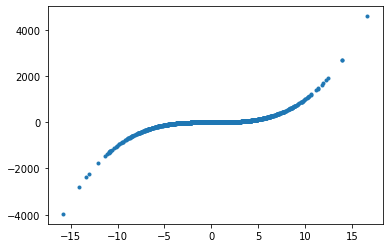

In [ ]:
# 두 특성이 선형 관계는 아니지만 단조 관계일 때를 살펴봅시다.(y=x^3)
x = np.random.normal(0, 5, 1000)
y = x**3 + np.random.normal(0, 1, 1000)

plt.plot(x, y, ".")

print("Pearson Corrcoef:", np.corrcoef(x, y)[0, 1])
print("Spearman Corrcoef:", spearmanr(x, y))

### [`sklearn.feature_selection.SelectKBest`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest)
- `sklearn`의 `SelectKBest` 모듈은 문제의 유형(분류 / 회귀)에 따라 다양한 통계량을 기반으로 특성을 선택할 수 있도록 해 줍니다.
- `SelectKBest`를 이용하여 통계량으로부터 특성을 선택해 봅시다.
  - `SelectKBest`의 `score_func` 인자를 바꿔 줌으로써 서로 다른 통계량으로부터 특성을 선택할 수 있습니다.

#### 대표적인 몇 가지 통계량 옵션(`score_func`)
- 분류 / 회귀 문제에 따라 적절한 옵션을 선택해야 합니다.
- **분류 타겟을 위한 옵션들**
  - `f_classif`
  - `mutual_info_classif`
  - `chi2`
- **회귀 타겟을 위한 옵션들**
  - `f_regression`
  - `mutual_info_regression`

In [ ]:
from category_encoders import OneHotEncoder

enc = OrdinalEncoder()
imp = SimpleImputer()

X_train_encoded = enc.fit_transform(X_train)
X_train_imputed = imp.fit_transform(X_train_encoded)

X_val_encoded = enc.transform(X_val)
X_val_imputed = imp.transform(X_val_encoded)

In [ ]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

selector = SelectKBest(score_func=mutual_info_classif, k=6)
X_train_selected = selector.fit_transform(X_train_imputed, y_train)
X_val_selected = selector.transform(X_val_imputed)

In [ ]:
print("선택된 특성: ", X_train_encoded.columns[selector.get_support()].tolist())

선택된 특성:  ['h1n1_knowledge', 'doctor_recc_h1n1', 'health_insurance', 'health_worker', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk']


In [ ]:
model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    n_estimators=200,
    random_state=42,
    n_jobs=-1,
    max_depth=6,
    min_child_weight=6,
    colsample_bytree=0.7,
    learning_rate=0.1,
    use_label_encoder=False,
)

model.fit(X_train_selected, y_train)
print("검증 AUC: ", model.score(X_val_selected, y_val))
print("특성 수:")
print("\tBefore: ", X_train.shape[1])
print("\tAfter: ", X_train_selected.shape[1])

검증 AUC:  0.8264737279089076
특성 수:
	Before:  32
	After:  6


## 👏 마무리
#### 이번 노트에서는 
- 학습의 최적화를 위해 하이퍼파라미터 튜닝을 하는 다양한 방법에 대해 배웠습니다. 
- 모델 성능 개선과 학습 효율을 위해 모델 예측에 영향을 많이 미치는 특성을 선택하는 방법에 대해 배웠습니다. 
<br></br>

#### 학습 후 아래 질문에 답해보세요.

1. 하이퍼파라미터 튜닝을 하는 방법으로 무엇이 있나요?
2. 왜 가장 먼저 하이퍼파라미터를 직접 튜닝해봐야 하나요?
3. Grid Search, Randomized Search, Bayesian Search의 차이점은 무엇인가요?
4. 학습에 유용한 특성을 선택하는 방법은 무엇이 있나요?


# References

- [Sklearn: Tuning the hyper-parameters of an estimator](https://scikit-learn.org/stable/modules/grid_search.html)
- [Sklearn: Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
- [Hyperopt: Distributed Asynchronous Hyper-parameter Optimization](http://hyperopt.github.io/hyperopt/)
- 데이터가 뛰어노는 AI 놀이터, 캐글 상위 랭킹 진입을 위한 필살기 (가도와키 다이스케, 사카타 류지, 호사카 게이스케, 히라마쓰 유지 저/대니얼WJ )